# Neural Network

## Understanding Artificial Neural Networks Theory

#### En el notebook anterior he utilizado la tecnica de regresion lineal, la cual es muy util, pero presenta el problema de que se supone que hay una relacion lineal entre las variables a estudiar

#### En este caso voy a utilizar redes neuronales, que se comportan bastante bien tanto cuando hay relaciones lineales como cuando no

[Informacion sobre las Redes Neuronales Artificiales](https://es.wikipedia.org/wiki/Red_neuronal_artificial)

## TensorFlow's High Level Estimator API

#### [TensorFlow](https://es.wikipedia.org/wiki/TensorFlow) es una biblioteca de código abierto para aprendizaje automático a través de un rango de tareas, y desarrollado por Google para satisfacer sus necesidades de sistemas capaces de construir y entrenar redes neuronales para detectar y descifrar patrones y correlaciones, análogos al aprendizaje y razonamiento usados por los humanos.


## Construyendo un DNNRegressor para predecir el clima

#### En este notebook voy a describir como usar uno de los estimadores mas potentes de redes neuronales, el [DNN Regressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor)

#### Importo las librerias que voy a usar

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import explained_variance_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split

#### Abro el DF exportado de la segunda parte

In [2]:
import pickle
with open('end-part2_df.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [3]:
# Muestro el DF
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tmed,912.0,14.646162,7.740936,0.5,8.375,12.60,21.05,32.5
tmed_1,912.0,14.649123,7.730972,0.5,8.400,12.60,21.05,32.5
tmed_2,912.0,14.642215,7.727721,0.5,8.400,12.60,21.05,32.5
tmed_3,912.0,14.637829,7.722571,0.5,8.375,12.60,21.05,32.5
tmin_1,912.0,8.295504,6.952217,-5.4,2.675,7.60,13.80,24.5
tmin_2,912.0,8.293860,6.950907,-5.4,2.700,7.60,13.80,24.5
tmin_3,912.0,8.294079,6.949257,-5.4,2.700,7.60,13.80,24.5
tmax_1,912.0,21.004276,9.060720,2.6,13.500,18.95,28.85,42.2
tmax_2,912.0,20.991776,9.056666,2.6,13.500,18.95,28.85,42.2
tmax_3,912.0,20.983114,9.050151,2.6,13.500,18.95,28.85,42.2


In [4]:
# Veo mas informacion sobre el, para tener una idea clara de como era
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 2018-01-04 to 2020-12-31
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmed    912 non-null    float64
 1   tmed_1  912 non-null    float64
 2   tmed_2  912 non-null    float64
 3   tmed_3  912 non-null    float64
 4   tmin_1  912 non-null    float64
 5   tmin_2  912 non-null    float64
 6   tmin_3  912 non-null    float64
 7   tmax_1  912 non-null    float64
 8   tmax_2  912 non-null    float64
 9   tmax_3  912 non-null    float64
dtypes: float64(10)
memory usage: 78.4+ KB


#### Se puede observar que hay menos de 1000 filas de datos, todos son de caracter numerico y ademas no hay datos nulos o que falten. Esto se debe al preprocesado hecho en el primer notebook

#### Separo los atributos predictores del atributo que buscamos predecir

In [5]:
#X sera un dataframe de pandas con todas las columnas excepto la de tmed
X = df[[col for col in df.columns if col != 'tmed']]

# y sera una serie de pandas de el atributo tmed
y = df['tmed']

#### Como en todas las aplicaciones supervisadas de machine learning, voy a dividir el dataset en varios, uno para training y otro para testing

#### Ademas, para explicar mejor el proceso iterativo de entrenar esta red neuronal, voy a usar un dataset adicional que sera para validacion

#### Para el entrenamiento voy a utilizar el 80% de la informacion y para testear y validar usare el 10% restante para cada dataset

In [6]:
# Separo los datos en un dataset para training y otro dataset temporal mediante sklearn.model_selection.traing_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)

In [7]:
# Cojo el restante 20% de los datos, que esta en X_temp y y_temp y los separo equitativamente
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

X_train.shape, X_test.shape, X_val.shape
print("Instancias de entrenamiento   {}, Caracteristicas de entrenamiento   {}".format(X_train.shape[0], X_train.shape[1]))
print("Instancias de validacion {}, Caracteristicas de validacion  {}".format(X_val.shape[0], X_val.shape[1]))
print("Instancias de testing    {}, Carcateristicas de testing    {}".format(X_test.shape[0], X_test.shape[1]))

Instancias de entrenamiento   729, Caracteristicas de entrenamiento   9
Instancias de validacion 92, Caracteristicas de validacion  9
Instancias de testing    91, Carcateristicas de testing    9


### Procedo a construir el DNN Regressor
#### El primer paso a dar cuando se construlle una red neuronal es instanciar la clase `tf.estimator.DNNRegressor(...)`. 
#### El constructor de esta clase tiene muchos parametros pero yo me voy a fijar solo en los siguientes: 
- `feature_columns`: Una lista muy parecida a una estructura que contiene la definicion del nombre y los tipos de datos que van a alimentar el modelo
- `hidden_units`: Una lista muy parecida a una estructura que contiene la definicion del numero de ancho y profundiad de la red neuronal
- `optimizer`: Es una instanica de la subclase `tf.Optimizer`, que optimiza los pesos del modelo durante el entrenamiento. Por defecto es el optimizador AdaGrad
- `activation_fn`: Una funcion de activacion que se usa para introducir no linealidad en la red en cada capa. Por defecto es [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
- `model_dir`: El directorio que se creara y contendra toda la metada y los puntos de control del modelo


#### Comienzo definiendo la lista de las columnas numericas relevantes. 
#### Para hacer esto uso la funcion `tf.feature_column.numeric_column()` que me devuelve una instancia de `FeatureColumn`

In [8]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

#### Ahora que ya tengo las columnas definidas, puedo instanciar la clase `DNNRegressor` y guardarla en la variable regresora. 
#### Especifico que quiero una red neuronal con dos capas profundas donde ambas capas tendran una anchura de 50 nodos. 
#### Tambien indico que la informacion de mi modelo se guarde en un directorio llamado tf_wk_model

In [9]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Lo siguiente cosa que quiero es definir una funcion reusable, que la llamare `wx_input_fn(...)`. Esta funcion sera usada para alimentar de datos mi red neuronal durante las fases de training y testing.

#### Hay muchas maneras de construir input functions, pero yo describire como definir y usar una basada en `tf.estimator.inputs.pandas_input_fn(...)` ya que mi informacion se encuentra en una estructura de datos panda

In [10]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X, 
                                                         y=y, 
                                                         batch_size=batch_size, 
                                                         num_epochs=num_epochs, 
                                                         shuffle=shuffle)

#### Se puede observar que la funcion `wx_input_fn(...)` toma un parametro obligatorio y 3 opcionales que los eligira tensorflow especificamente para los datos panda en la funcion que es retornada. Esta es una de las potentes caracteristicas del API de TensorFlow

#### Los parametros de la funcion se definen de la siguiente manera:
- `X` : Las caracteristicas de entrada que alimentaran uno de los 3 metodos de mi `DNNRegressor`, (`train`, `evaluate` y `predict`)
- `y` : Los valores objetivo de `X` que son opcionales y no seran proporcionados a la llamada de `predict`
- `num_epochs` : Parametro opcional que sirve para especificar el numero de epocas. Una epoca ocurre cuando el algoritmo se ejecuta sobre todo el dataset una vez
- `shuffle` : Parametro opcional, que especifica si seleccionar de forma random una pequeña parte del dataset cada vez que el algoritmo se ejecuta
- `batch_size` : El numero de ejemplos a incluir cada vez que el algoritmo se ejecuta

#### Ahora que ya tengo la funcion definida, procedo a entrenar la red neuronal

#### Defino un simple bucle de entrenamiento para entrenar el modelo con la training data y evaluarlo periodicamente con la evaluation data

#### El bucle siguiente itera 100 veces. En el cuerpo del bucle llamo al metodo del objeto regresor `train(...)`, pasandole mi funcion reusable `wx_input_fn(...)`. 
#### He dejado adrede el `num_epochs` a None, que quiere decir que no me importa el numero de veces que pase sobre el set de entrenamiento, solamente quiero que se mantenga el algoritmo de entrenamiento con un `batch_size` de 400, que es mas o menos la mitad del dataset. 
#### Tambien dejo el valor por defecto del parametro `shuffle`, es decir a `True` lo que significa que durante el entrenamiento, la data es seleccionada de forma aleatoria para evitar relaciones secuenciales.
#### El ultimo parametro, `steps`, que vale 400, significa que el training set va a ser procesado 400 veces por iteracion

In [11]:
evaluations = []
STEPS = 400
for i in range(20):
    print(i)
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

0

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 

#### Para explicar porque ejecuto `evaluate(...)` en cada ejecucion del bucle y almaceno su resultado en una lista, voy a explicar que ocurre cuando se ejecuta `train(...)`
#### Este metodo selecciona un lote aleatorio de datos y lo introduce en la red hasta que se hace la prediccion, y para cada registro se calcula la funcion de perdida (loss function)
#### Despues, a partir del calculo de la funcion de perdida, los pesos son ajustados de acuerdo a lo que diga la logica del optimizador, que busca hacer ajustes de modo que se reduzca la perdida total en la siguiente iteracion
#### Los valores de perdida por lo general, van disminuyendo con las iteraciones, pero hay un cierto punto donde la red puede verse influida por ruido heredado de los datos y deja de ser valida para futuras predicciones
#### Por eso mismo almaceno el valor de cada evaluacion en una lista, para a continuacion realizar una grafica con los valores de perdida. De este modo podre vigilar que la red no lega a ese punto donde ya no nos seria util. Cuando la red llega a este punto, se dice que esta overfitted

#### Realizo una grafica que muestre como va evolucionando la funcion de loss con las iteraciones

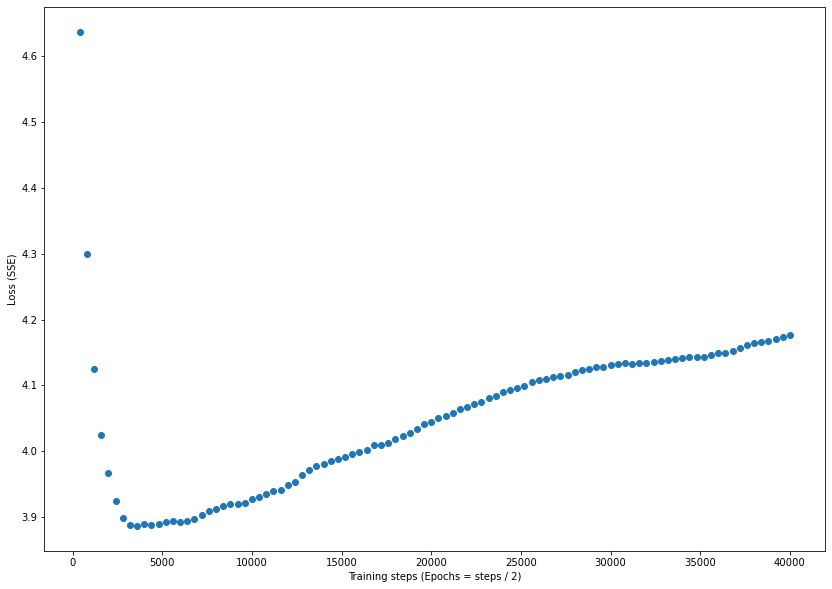

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.show()

#### Como podemos observar, la red no llega a estar overfitted, el valor se estabiliza entre 4.0 y 4.5 así que las oscilaciones no son demasiado determinantes

#### A continuacion voy a hacer la prediccion y a comparar la desviacion de los valores obtenidos respecto a los que deberia obtener

In [15]:
# hago una prediccion usando el dataset de test
pred = regressor.predict(input_fn=wx_input_fn(X_test,
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

# Evaluo la exactitud de la prediccion
print("Variacion explicada: %.2f" % explained_variance_score(
                                            y_test, predictions))  
print("Error absoluto medio %.2f grados centigados" % mean_absolute_error(
                                            y_test, predictions))  
print("Desviación media absoluta: %.2f grados centigrados" % median_absolute_error(
                                            y_test, predictions))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Variacion explicada: 0.95
Error absoluto medio 1.45 grados centigados
Desviación media absoluta: 1.30 grados centigrados


- La variación explicada mide la proporción en la que un modelo matemático explica la variación ( dispersión ) de un conjunto de datos dado
- El error absoluto medio es una medida de la diferencia entre dos variables continuas. Considerando dos series de datos (unos calculados y otros observados) relativos a un mismo fenómeno, el error absoluto medio sirve para cuantificar la precisión de una técnica de predicción comparando por ejemplo los valores predichos frente a los observados, el tiempo real frente al tiempo previsto, o una técnica de medición frente a otra técnica alternativa de medición.
- La desviación media absoluta de un conjunto de datos es la distancia promedio entre cada valor y el promedio. La desviación media absoluta es una manera de describir la variación en un conjunto de datos. La desviación media absoluta nos ayuda a tener una idea de qué tan "extendidos" están los valores en un conjunto de datos.

#### Hemos obtenido algo de mejora respecto a la regresion lineal, cuya varianza era de 0.93

#### La conclusion que he obtenido de este proyecto, es que no existe un modelo optimo. Cada dataSet es unico y se debe buscar el modelo mas optimo a base de prueba y error.
#### Actualmente tenemos la ventaja de contar con librerias como esta de TensorFLow que son muy potentes y muy faciles de usar, lo que permite cambiar de modelo rapidamente